# IE6511 Homework 8
Done by: Aloisius Stephen and Yang Xiaozhou

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pySOT import *
from poap.controller import SerialController, ThreadController, BasicWorkerThread
%matplotlib inline
np.random.seed(6511)
np.set_printoptions(precision=3)

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

## 1. Using PySOT with constraint handling on Keane’s Bump function (10 Points)

a) Keane's Bump with self-implementation of penalty function

In [10]:
class KeaneConsPenalty:
    def __init__(self, dim=20):
        self.xlow = np.zeros(dim)
        self.xup = 5 * np.ones(dim)
        self.dim = dim
        self.min = -0.835
        self.integer = []
        self.continuous = np.arange(0, dim)
        self.info = str(dim)+"-dimensional Keane bump function \n" +\
                             "Global optimum: -0.835 for large n"

    # Evaluate the objective function for a single data point
    def objfunction(self, x):
        """Evaluate the Keane function  at x

        :param x: Data point
        :return: Value at x
        """
        n = len(x)
        f = -abs((sum(np.cos(x)**4)-2 * np.prod(np.cos(x)**2)) /
                    max([1E-10, np.sqrt(np.dot(1+np.arange(n), x**2))]))
        p = np.power(10,6)*(np.maximum(0,0.75 - np.prod(x)) 
                    + np.maximum(0,np.sum(x) - 7.5 * self.dim))
        return f + p


Number of threads: 1
Maximum number of evaluations: 300
Search strategy: CandidateDYCORS
Experimental design: Latin Hypercube
Surrogate: Cubic RBF, domain scaled to unit box
20-dimensional Keane bump function 
Global optimum: -0.835 for large n


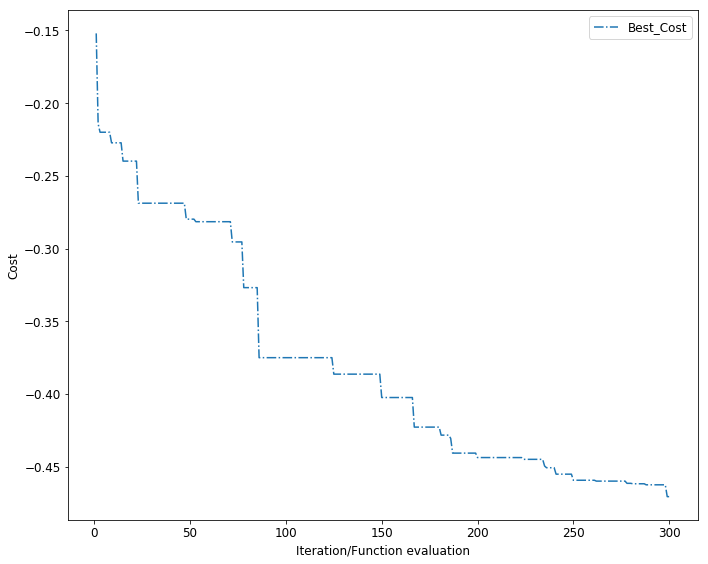

In [11]:
nthreads = 1 # serial
maxeval = 300 
penalty = 1e6 
nsamples = nthreads
trial = 20

#Print setting of PySOT 
print("\nNumber of threads: " + str(nthreads))
print("Maximum number of evaluations: " + str(maxeval))
print("Search strategy: CandidateDYCORS")
print("Experimental design: Latin Hypercube")
print("Surrogate: Cubic RBF, domain scaled to unit box")

# Initiate instance of the CostFunction class you created
data = KeaneConsPenalty(dim=20) 
print(data.info)

# Create a strategy  and a controller 
controller = ThreadController() 
controller.strategy = \
    SyncStrategyNoConstraints(
        worker_id=0, data=data,
        maxeval=maxeval, nsamples=nsamples,
        response_surface=RBFInterpolant(kernel=CubicKernel, maxp=maxeval),
        exp_design=LatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
        sampling_method=CandidateDYCORS(data=data, numcand=100*data.dim))

# Launch the threads with given objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)
    
# Run the optimization strategy once
result = controller.run()
fvals = np.array([o.value for o in controller.fevals])

Iter = np.arange(1,maxeval+1)
Trial_best_Keane_Penalty = np.column_stack((Iter,np.minimum.accumulate(fvals)))

# Run the rest of the trials 
for i  in range(1,trial):
    result = controller.run()
    fvals = np.array([o.value for o in controller.fevals])
    Trial_best_Keane_Penalty = np.concatenate((Trial_best_Keane_Penalty, 
                                        np.column_stack((Iter,np.minimum.accumulate(fvals)))), axis=0)
    
Trial_best_Keane_Penalty_df = pd.DataFrame(Trial_best_Keane_Penalty, columns = ['Iteration','Cost'])

# Average of Best_Cost plot
plt.figure(figsize=[10,8])
plt.plot(Trial_best_Keane_Penalty_df.groupby('Iteration').mean().Cost, '-.')
plt.xlabel('Iteration/Function evaluation')
plt.ylabel('Cost')
plt.legend(['Best_Cost'])
plt.tight_layout()

b) Keane's Bump with pySOT Constraint handling

In [12]:
class KeaneCons:
    def __init__(self, dim=10):
        self.xlow = np.zeros(dim)
        self.xup = 5 * np.ones(dim)
        self.dim = dim
        self.min = -0.835
        self.integer = []
        self.continuous = np.arange(0, dim)
        self.info = str(dim)+"-dimensional Keane bump function \n" +\
                             "Global optimum: -0.835 for large n"

    # Return a list with the constraint function at the given point
    def eval_ineq_constraints(self, x):
        vec = np.zeros((x.shape[0], 2))
        vec[:, 0] = 0.75 - np.prod(x) # Constraint 1
        vec[:, 1] = np.sum(x) - 7.5 * self.dim # Constraint 2
        return vec


    # Evaluate the objective function for a single data point
    def objfunction(self, x):
        """Evaluate the Keane function  at x

        :param x: Data point
        :return: Value at x
        """
        n = len(x)
        return -abs((sum(np.cos(x)**4)-2 * np.prod(np.cos(x)**2)) /
                    max([1E-10, np.sqrt(np.dot(1+np.arange(n), x**2))]))


Number of threads: 1
Maximum number of evaluations: 300
Search strategy: CandidateDYCORS
Experimental design: Latin Hypercube
Surrogate: Cubic RBF, domain scaled to unit box
20-dimensional Keane bump function 
Global optimum: -0.835 for large n


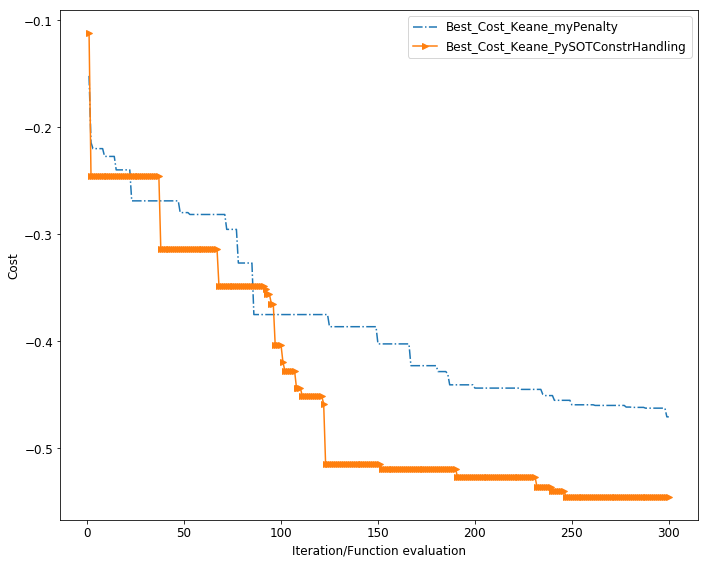

In [14]:
nthreads = 1 # serial
maxeval = 300 
penalty = 1e6 
nsamples = nthreads
trial = 20

#Print setting of PySOT 
print("\nNumber of threads: " + str(nthreads))
print("Maximum number of evaluations: " + str(maxeval))
print("Search strategy: CandidateDYCORS")
print("Experimental design: Latin Hypercube")
print("Surrogate: Cubic RBF, domain scaled to unit box")

# Initiate instance of the CostFunction class you created
data = KeaneCons(dim=20) 
print(data.info)

# Create a strategy  and a controller 
controller = ThreadController() 
controller.strategy = \
    SyncStrategyPenalty(
        worker_id=0, data=data,
        maxeval=maxeval, nsamples=nsamples,
        response_surface=RBFInterpolant(kernel=CubicKernel, maxp=maxeval),
        exp_design=LatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
        sampling_method=CandidateDYCORS(data=data, numcand=100*data.dim),
        penalty=penalty)

# Launch the threads with given objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)
    
# Run the optimization strategy once
result = controller.run()
fvals = np.array([o.value for o in controller.fevals])

Iter = np.arange(1,maxeval+1)
Trial_best_Keane_ConstrHandling = np.column_stack((Iter,np.minimum.accumulate(fvals)))

# Run the rest of the trials 
for i  in range(1,trial):
    result = controller.run()
    fvals = np.array([o.value for o in controller.fevals])
    Trial_best_Keane_ConstrHandling = np.concatenate((Trial_best_Keane_ConstrHandling, 
                                        np.column_stack((Iter,np.minimum.accumulate(fvals)))), axis=0)
    
Trial_best_Keane_ConstrHandling_df = pd.DataFrame(Trial_best_Keane_ConstrHandling, columns = ['Iteration','Cost'])

# Average of Best_Cost plot
plt.figure(figsize=[10,8])
plt.plot(Trial_best_Keane_Penalty_df.groupby('Iteration').mean().Cost, '-.')
plt.plot(Trial_best_Keane_ConstrHandling_df.groupby('Iteration').mean().Cost, '->')
plt.xlabel('Iteration/Function evaluation')
plt.ylabel('Cost')
plt.legend(['Best_Cost_Keane_myPenalty', 'Best_Cost_Keane_PySOTConstrHandling'])
plt.tight_layout()

### c.	From just looking at the plot developed in 1(b), which penalty handling method works better for Keane’s Bump Function? 

The penalty handling method which is built-in PySOT works better for this experiment with Keane's Bump function

## 2.	(Computer Usage) Setting up SO-MI in PySOT (15 points)

## 3.	Short Answer Questions (no computer necessary)

Statements: <br>
_A.	Uses non-dominated sorting to evaluate fitness of solutions._ <br>
True for  NSGA-II only

_B.	Uses the Hypervolume metric to select new points for expensive evaluation._ <br>
True for GOMORS only

_C.	Can select more than one point for expensive evaluation in each algorithm iteration._<br> 
True for both GOMORS and NSGA-II

_D.	Uses Kriging surrogate (Gaussian Process Model) to help pick a point for expensive evaluation._<br> 
Neither of the two algorithm

_E.	Can be applied to problems with more than two objectives._ <br>
True for both GOMORS and NSGA-II

**What characteristics of your problem and the number of available evaluations would help you select among the 2 algorithms mentioned above? How many surrogate surfaces are fitted in GOMORS?**

If there are only a limited number of available evaluations, or calculation of objective function is expensive, then GOMORS should be chosen.  

In GOMORS the surrogate surgaface fitted is equal to the number of objectives in the problem.

### 4.	Explain what “restart” is for some surrogate global optimization methods.Explain  when and why LMSRBF will restart and answer the same question for DYCORS. Is there a difference between the two methods.  Explain the advantages and disadvantages of restarting.

"Restart" refers to re-initializing using a different experiment design.

For LMSRBF, it will restart when it appears to have converged to a local optimum. The restart happens if the number of consecutive 'failed' iteration exceeds the pre-determined tolerance parameter. <br>
This restart is carried out so that the search will be able to get out of a local optimum and a global optimization can be achieved.

# For DYCORS, ...

The advantage is that starting with a clean slate allows for the algorithm to search in a new trajectory, and helps it to find a new local optimum point.

The disadvantage is the significant number of evaluations needed to get a new experimental design, such as 2(d+1) points in the Symmetric Latin Hypercube Design, for each restart.

### 5.	Assume you have a 15 dimensional decision vector $X_i^A$, where $X_i^A$, A = LMSRBF or DYCORS to indicate the algorithm. So $X_i^L$ refers to the value of the decision vector in the I-th iteration of the LMSRBF algorithm. Let $n_o$ be the number of evaluations done for the Latin Hypercube evaluation. So what can you say about the expected Euclidean distance from $X_i^L$ to $X_{i+1}^L$ versus the expected Euclidean distance $X_i^D$ to  $X_{i+1}^D$?

The expected Euclidean distance from $X_i^L$ to $X_{i+1}^L$ is more likely to be larger than that of the expected Euclidean distance $X_i^D$ to  $X_{i+1}^D$. This is because for the LMSRBF, all the coordinates of the $X_i^L$ decision vector is perturbed in each iteration, whereas in the case of DYCORS the number of coordinates to be perturbed decreases as the iterations increases, and should therefore have smaller the Euclidean distance between $X_i^D$ and the $X_{i+1}^D$.